# Final Assignment

In this notebook we are going to analyze the data from departures and arrives in USA in Aug 2017

Let's begin by defining the SparkContext and the SQLContext

In [1]:
# In this case, these lines are commented since Spark and SQL context are
# defined already by default

# from pyspark import SparkContext
# sc = SparkContext()
# from pyspark.sql import SQLContext
# sqlContext=SQLContext(sc)

Let's bring in the dataset through databricks. The dataset has to be located in hdfs hadoop system

In [2]:
bd = sqlContext.read.format("com.databricks.spark.csv"
).option("header", "true"
).load("On_Time_On_Time_Performance_2017_8.csv", inferSchema=True)

bd

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: string, UniqueCarrier: string, AirlineID: int, Carrier: string, TailNum: string, FlightNum: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, CancellationCode: string, Diverted: double, CRSElapsedTime: double, ActualElap

There's a lot of variable we are not intersted in, so let's choose the relevant features to out analysis

In [3]:
bd=bd.select('Year','Month','DayofMonth','DayOfWeek','CRSDepTime',
             'UniqueCarrier', 'TailNum', 'ArrDelay','DepDelay','Origin',
             'Dest','Distance','Cancelled', 'Diverted', 'CarrierDelay',
             'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay')
bd.dtypes

[('Year', 'int'),
 ('Month', 'int'),
 ('DayofMonth', 'int'),
 ('DayOfWeek', 'int'),
 ('CRSDepTime', 'int'),
 ('UniqueCarrier', 'string'),
 ('TailNum', 'string'),
 ('ArrDelay', 'double'),
 ('DepDelay', 'double'),
 ('Origin', 'string'),
 ('Dest', 'string'),
 ('Distance', 'double'),
 ('Cancelled', 'double'),
 ('Diverted', 'double'),
 ('CarrierDelay', 'double'),
 ('WeatherDelay', 'double'),
 ('NASDelay', 'double'),
 ('SecurityDelay', 'double'),
 ('LateAircraftDelay', 'double')]

In [4]:
# number of lines
bd.count()

510451

# Analysis I

In the first analysis we work with the cancelled flights, so we start by dropping the diverted flights, namely we want the lines where 'Diverted' == 0

In [5]:
bd = bd.filter(bd.Diverted == 0)
bd.count()

509165

Also the database has nan values in columns such as CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, y LateAircraftDelay, which we replace them by 0

In [6]:
bd = bd.na.fill({'CarrierDelay':0, 'WeatherDelay':0,'NASDelay':0,
                 'SecurityDelay':0, 'LateAircraftDelay':0})

Create a new column to know whether or not the flight has been in the afternoon

In [7]:
bd = bd.withColumn('Afternoon',(bd.CRSDepTime<2100)&(bd.CRSDepTime>=1600))

# let's visualize data into table
sqlContext.registerDataFrameAsTable(bd, "bd")
df_db = sqlContext.sql("SELECT * FROM bd")
df_db.toPandas().head(5)

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,TailNum,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Afternoon
0,2017,8,25,5,2318,UA,N66831,-1.0,-7.0,SFO,RDU,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,2017,8,25,5,1235,UA,N76288,-3.0,-1.0,ORD,MSY,837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,2017,8,25,5,2110,UA,N17244,0.0,-1.0,ITO,LAX,2449.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,2017,8,25,5,737,UA,N439UA,-22.0,-9.0,JAC,ORD,1162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,2017,8,25,5,618,UA,N72405,-21.0,-6.0,MCI,IAH,643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


Let's answer the following questions:

- What is the percent of afternoon flight has been cancelled? 

In [25]:
df_afternoon = sqlContext.sql("SELECT q1.cnt, q2.cnt, q2.cnt/q1.cnt * 100 \
                                FROM (SELECT COUNT(*) as cnt FROM bd \
                                WHERE Afternoon = True) AS q1, \
                                (SELECT COUNT(*) as cnt FROM bd \
                                WHERE Afternoon = True AND Cancelled = 1.0) AS q2")
df_afternoon.toPandas()

,cnt,cnt,_c2
0,143356,3629,2.53146


- What is the average distance for the cancelled flights?

In [10]:
df_distance = sqlContext.sql("SELECT AVG(Distance) FROM bd \
                                WHERE Cancelled = 1.0")
df_distance.toPandas()

,_c0
0,749.870569


- Which airport has the greatest rate of cancelled flights?

In [21]:
df_cancelled = sqlContext.sql("SELECT q1.Origin, q1.cnt, q2.cnt, q2.cnt/q1.cnt*100 as rate \
                                FROM (SELECT Origin, COUNT(*) as cnt FROM bd \
                                        GROUP BY Origin) AS q1\
                                JOIN (SELECT Origin, COUNT(*) as cnt FROM bd \
                                        WHERE Cancelled = 1.0\
                                        GROUP BY Origin) AS q2\
                                ON q2.Origin = q1.Origin\
                                ORDER BY rate DESC\
                                LIMIT 10")
df_cancelled.toPandas()

,Origin,cnt,cnt,rate
0,CRP,205,45,21.951220
1,HOU,4724,896,18.966977
2,LCH,82,15,18.292683
3,HRL,208,38,18.269231
4,HOB,55,10,18.181818
5,IAH,11103,1949,17.553814
6,BRO,81,14,17.283951
7,AEX,94,14,14.893617
8,MTJ,42,6,14.285714
9,CLL,98,12,12.244898


Now let's define the dataset we are going to use to train and test the Machine Learning Model

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# these're the columns we use
a1 = VectorAssembler(inputCols=['DayofMonth','DayOfWeek',"Afternoon",'Distance'],outputCol='features')
# Cancelled is the target variable
bd2 = a1.transform(bd).select(col("Cancelled").cast('double').alias("label"), 'features')

Then we split data into train and test data

In [9]:
(bd2_train, bd2_test) = bd2.randomSplit([0.7, 0.3],seed=123)
print(bd2_train.count())
print(bd2_test.count())

356250
152915


## Training Models

### Logistic Regression

In [28]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     threshold=0.5)
                        
model_lgr = lgr.fit(bd2_train)

In [29]:
print(model_lgr.intercept,model_lgr.coefficients)

-3.9162457845787597 [0.00990094371515,-0.00480166397927,0.0403291777531,-5.02347797691e-05]


Let's see the performance of this model using the AUC metric

In [30]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

pred = model.transform(bd2_test)

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+-----+------------------+--------------------+--------------------+----------+-----------+
|label|          features|       rawPrediction|         probability|prediction|      probs|
+-----+------------------+--------------------+--------------------+----------+-----------+
|  0.0|[1.0,2.0,0.0,31.0]|[3.91750544699499...|[0.98049727079217...|       0.0| 0.01950273|
|  0.0|[1.0,2.0,0.0,66.0]|[3.91926366428691...|[0.98053086369007...|       0.0|0.019469136|
|  0.0|[1.0,2.0,0.0,66.0]|[3.91926366428691...|[0.98053086369007...|       0.0|0.019469136|
|  0.0|[1.0,2.0,0.0,67.0]|[3.91931389906668...|[0.98053182265334...|       0.0|0.019468177|
|  0.0|[1.0,2.0,0.0,67.0]|[3.91931389906668...|[0.98053182265334...|       0.0|0.019468177|
|  0.0|[1.0,2.0,0.0,67.0]|[3.91931389906668...|[0.98053182265334...|       0.0|0.019468177|
|  0.0|[1.0,2.0,0.0,67.0]|[3.91931389906668...|[0.98053182265334...|       0.0|0.019468177|
|  0.0|[1.0,2.0,0.0,67.0]|[3.91931389906668...|[0.98053182265334...|       0.0|0

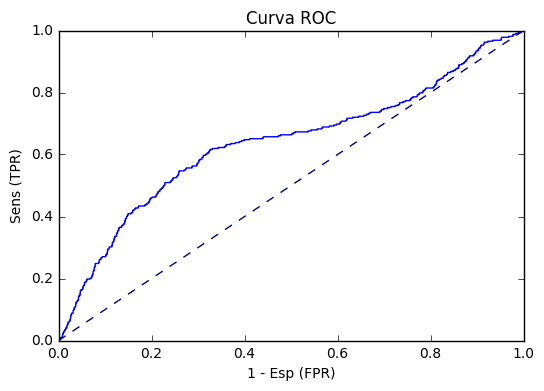

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

df = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( df['label'], df['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))
print('AUC=',BCE(metricName="areaUnderROC").evaluate(pred))

AUC= 0.6384399164674139
AUC= 0.6384399164674162


### Random Forest

In [11]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexed')
bd3 = stringIndexer.fit(bd2).transform(bd2)

(bd3_train, bd3_test) = bd3.randomSplit([0.7, 0.3],seed=123)
print(bd3_train.count())
print(bd3_test.count())

356250
152915


In [37]:
from pyspark.ml.classification import RandomForestClassifier
from time import time

start_time = time()

# Train a RandomForest model.
RF = RandomForestClassifier(
    labelCol="indexed",
    featuresCol="features",
    numTrees=500,
    maxDepth=3,
    seed =123,
    featureSubsetStrategy="sqrt",
    impurity='gini')

model = RF.fit(bd3_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 156.299 seconds


In [38]:
pred_rf = model.transform(bd3_test)
print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred_rf))

AUC= 0.781371785359251


### Neural Networks

In [12]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCCE

MLC = MultilayerPerceptronClassifier(
    labelCol="label",
    featuresCol="features",
    maxIter=100,
    layers=[4, 5, 2],
    seed=123)

model_nn = MLC.fit(bd3_train)

pred_nn = model_nn.transform(bd3_test)

precision_nn = MCCE(metricName="precision")
precision_nn.evaluate(pred_nn)

0.9787529019389857

# Analysis II

For this second analysis let's work on delay flights, so canceled and diverted flights are putted away

In [34]:
# the actual db has already filtered diverted flights
bd = bd.filter((bd.Diverted == 0) & (bd.Cancelled == 0))
bd.count()

498163

and let's define a new effective delay (ArrDelay - LateAircraftDelay)

In [35]:
bd = bd.withColumn('Effective_Delay',(bd.ArrDelay - bd.LateAircraftDelay))
sqlContext.registerDataFrameAsTable(bd, "bd")
df_db = sqlContext.sql("SELECT * FROM bd")
df_db.toPandas().head(5)

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,TailNum,ArrDelay,DepDelay,Origin,...,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Afternoon,Effective_Delay
0,2017,8,25,5,2318,UA,N66831,-1.0,-7.0,SFO,...,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-1.0
1,2017,8,25,5,1235,UA,N76288,-3.0,-1.0,ORD,...,837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-3.0
2,2017,8,25,5,2110,UA,N17244,0.0,-1.0,ITO,...,2449.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0
3,2017,8,25,5,737,UA,N439UA,-22.0,-9.0,JAC,...,1162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-22.0
4,2017,8,25,5,618,UA,N72405,-21.0,-6.0,MCI,...,643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-21.0


- What is the average on Effective Delay?

In [15]:
df_avg = sqlContext.sql("SELECT AVG(Effective_Delay) FROM bd")
df_avg.toPandas()

,_c0
0,1.2536


- Which origin airport has the greatest mean effective delay?

In [17]:
df_oa = sqlContext.sql("SELECT Origin, AVG(Effective_Delay) as eff_delay FROM bd\
                        GROUP BY Origin\
                        ORDER BY eff_delay DESC\
                        LIMIT 10")
df_oa.toPandas()

,Origin,eff_delay
0,RDD,35.887640
1,PIB,32.262295
2,BGR,29.550725
3,WYS,25.440678
4,STS,24.268456
5,ADK,23.777778
6,CIU,22.157895
7,MVY,19.270270
8,ESC,17.888889
9,BQK,17.405405


- What is the correlation between DepDelay and Effective Delay?

In [19]:
df_corr = bd.sample(False, 0.1, 0).select('DepDelay','Effective_Delay').toPandas()
df_corr.corr()

,DepDelay,Effective_Delay
DepDelay,1.000000,0.779268
Effective_Delay,0.779268,1.000000


In [36]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# these're the columns we use
a2 = VectorAssembler(inputCols=['DayofMonth','DayOfWeek',"Afternoon",'Distance'],outputCol='features')
# Cancelled is the target variable
bd5 = a2.transform(bd).select(col("Effective_Delay").cast('double').alias("label"), 'features')

bd5.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| -1.0|[25.0,5.0,0.0,240...|
| -3.0|[25.0,5.0,0.0,837.0]|
|  0.0|[25.0,5.0,0.0,244...|
|-22.0|[25.0,5.0,0.0,116...|
|-21.0|[25.0,5.0,0.0,643.0]|
|  6.0|[25.0,5.0,1.0,733.0]|
|-17.0|[25.0,5.0,1.0,117...|
|-11.0|[25.0,5.0,0.0,133...|
|-14.0|[25.0,5.0,1.0,937.0]|
| 59.0|[25.0,5.0,0.0,447.0]|
|-13.0|[25.0,5.0,1.0,414.0]|
|-30.0|[25.0,5.0,1.0,146...|
|-22.0|[25.0,5.0,0.0,258...|
| -9.0|[25.0,5.0,1.0,250...|
|  0.0|[25.0,5.0,1.0,305.0]|
| 41.0|[25.0,5.0,0.0,213...|
|-20.0|[25.0,5.0,0.0,236...|
|-22.0|[25.0,5.0,0.0,334.0]|
|  0.0|[25.0,5.0,1.0,925.0]|
|-12.0|[25.0,5.0,1.0,236...|
+-----+--------------------+
only showing top 20 rows



In [37]:
# split data
(bd5_train, bd5_test) = bd5.randomSplit([0.7, 0.3],seed=456)
print(bd5_train.count())
print(bd5_test.count())

348793
149370


## Training Models

### Linear Regression

In [40]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
model_lr = lr.fit(bd5_train)

print(model_lr.intercept,model_lr.coefficients)

5.882600960496099 [-0.286602380218,-0.205341563383,4.55967715014,-0.000686724049529]


In [43]:
from pyspark.ml.evaluation import RegressionEvaluator

pred_train = model_lr.transform(bd5_train)

print('RMSE =', RegressionEvaluator(metricName="rmse").evaluate(pred_train))
print('R2 =', RegressionEvaluator(metricName="r2").evaluate(pred_train))

RMSE = 36.93974095780497
R2 = 0.0080028055571707


In [44]:
pred_test = model_lr.transformsform(bd5_test)
print('R2_test =', RegressionEvaluator(metricName="r2").evaluate(pred_test))

R2_test = 0.007609280359122228


### Decision Trees

In [42]:
from pyspark.ml.regression import DecisionTreeRegressor as DTR
from pyspark.ml.evaluation import RegressionEvaluator

rt = DTR(maxDepth=10)
model_rt = rt.fit(bd5_train)

pred_train = model_rt.transform(bd5_train)
pred_test = model_rt.transform(bd5_test)

print('R2_train =', RegressionEvaluator(metricName="r2").evaluate(pred_train))
print('R2_test =', RegressionEvaluator(metricName="r2").evaluate(pred_test))

R2_train = 0.026350129846489545
R2_test = 0.01913367467939564
